### 1. Imports

In [2]:
import pandas as pd

# visualization import
import matplotlib.pyplot as plt

# nltk imports
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# scipy import
from scipy import stats

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer

### 2. Reading in the Data

In [3]:
# read in data
df = pd.read_csv('./data/scraped_reddit_data.csv')

# drop extra index col
df.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

df.head()

,post,title,subreddit,upvotes,downvotes
0,"So a bit of backstory, I did my lifeguarding q...",People don't get US - At ALL.,ADHD,1,0
1,"So, Adderall IRs were a total no-go for me. Sw...",Adderall Making Me Super Anxious (AAAAA),ADHD,2,0
2,Regular Ritalin IR works well but I don’t like...,Anything that releases methylphenidate constan...,ADHD,1,0
3,I started vyvanse a few months ago. \n\n10 mg ...,Vyvanse side effects // any other paths?,ADHD,1,0
4,"Evening, has anyone who has a documented diagn...",Question (GP testing),ADHD,1,0


### 3. Data Cleaning

In [4]:
# searching for missing values
df.isna().sum()

post         184
title          0
subreddit      0
upvotes        0
downvotes      0
dtype: int64

Some reddit posts contain the actual 'post' itself in the title, so posts that are empty likely have all their information in the title. Therefore, instead of dropping these missing values, I will fill the missing values with empty strings to avoid issues with count vectorizing later on.

In [5]:
# let's fill missing values with an empty string
df['post'].fillna('', inplace = True)

# verifying
df.isna().sum()

post         0
title        0
subreddit    0
upvotes      0
downvotes    0
dtype: int64

I initially included up & downvotes to use as part of my model's features. My guess was that there could be a difference in participation rates for the two subreddits, so this could be helpful for the classification aspect. However, since I am only looking at the 1000 most recent posts per subreddit, the posts that are older are just going to have more interaction (higher/lower up and downvotes). Therefore, I am deciding to omit `upvotes` and `downvotes`.

In [6]:
# drop up/downvote cols
df.drop(columns = ['upvotes', 'downvotes'], axis = 1, inplace = True)

Before doing any EDA that might help analyze the dataset prior to modeling, I will clean up the `post` and `title` columns and rewrite them by removing special non-alphanumeric characters using `RegexpTokenizer`.

In [7]:
# instantiate tokenizer
tokenizer = RegexpTokenizer(r"\b\w+(?:['-]\w+)*\b")

# tokenize 'post' and 'title' to get rid of special characters
df['post'] = [' '.join(tokenizer.tokenize(p)) for p in df['post']]
df['title'] = [' '.join(tokenizer.tokenize(p)) for p in df['title']]

#### 3a. EDA on Posts and Titles & NLP

Before beginning the modeling process, I want to quantifiably explore my `post` and `title` data. I can also quantify the overall sentiment of a post using `SentimentIntensityAnalyzer`, so I will observe this too. The ***goal*** is to see if there are any stark differences between posts & titles in r/ADHD and r/autism *aside* from just the different words used. If there are specific differences, I will include those features in my model(s) to strengthen the classification.

Since I tokenized the `post` and `title` columns, I can do counts for the number of words in each columns. Let's also make a column that shows us the proportion of stopwords in each post.

In [8]:
# word counts for post & title
df['post_word_count'] = [len(i.split()) for i in df['post']]
df['title_word_count'] = [len(i.split()) for i in df['title']]

# function to count stopwords in a string
def count_stopwords(text):
    count = 0
    
    for word in text.split():
        if word.lower() in stopwords.words('english'):
            count += 1
    
    return count

In [9]:
# now, let's make a column that gives the proportion of stopwords
df['post_stopwords_prop'] = [round(count_stopwords(i)/len(i.split()),2) if len(i)>0 else 0 for i in df['post'] ]

In [10]:
# set up SentimentAnalyzer
sent = SentimentIntensityAnalyzer()

In [11]:
# add col that shows pos vs. neg (1 = more positive, 0 = more negative)
df['positive post'] = [1 if sent.polarity_scores(i)['pos'] > sent.polarity_scores(i)['neg'] else 0 for i in df['post']]

In [12]:
df.head()

,post,title,subreddit,post_word_count,title_word_count,post_stopwords_prop,positive post
0,So a bit of backstory I did my lifeguarding qu...,People don't get US At ALL,ADHD,157,6,0.56,1
1,So Adderall IRs were a total no-go for me Swit...,Adderall Making Me Super Anxious AAAAA,ADHD,219,6,0.44,1
2,Regular Ritalin IR works well but I don t like...,Anything that releases methylphenidate constan...,ADHD,61,11,0.43,1
3,I started vyvanse a few months ago 10 mg dose ...,Vyvanse side effects any other paths,ADHD,259,6,0.48,0
4,Evening has anyone who has a documented diagno...,Question GP testing,ADHD,67,3,0.51,0


#### 3b. Distribution of Post & Title Lengths
Let's first look at the distribution of post & title lengths by word count and see if there are any specific differences.

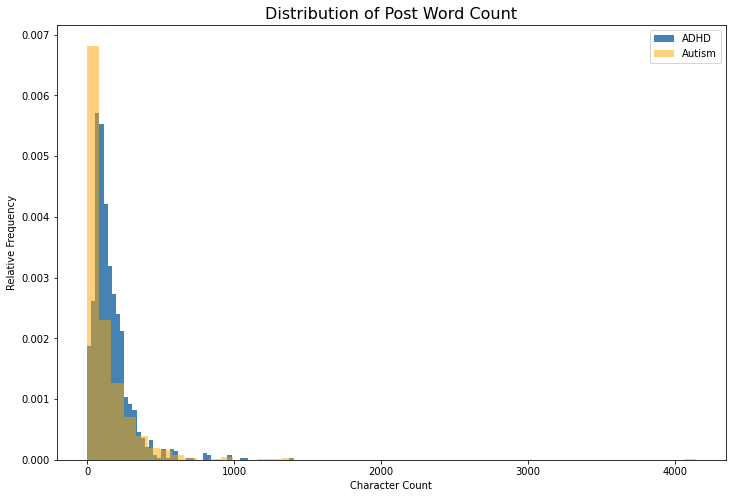

In [13]:
# post word count distribution
plt.figure(figsize = (12,8))
plt.hist(x = df[df['subreddit'] == 'ADHD']['post_word_count'], bins = 50, color = 'steelblue', density = True, label = 'ADHD')
plt.hist(x = df[df['subreddit'] == 'autism']['post_word_count'], bins = 50, color = 'orange', density = True, alpha = 0.5, label = 'Autism')
plt.title("Distribution of Post Word Count", size = 16)
plt.ylabel("Relative Frequency", size = 10)
plt.xlabel("Character Count", size = 10)
plt.legend()

# saving
plt.savefig('./graphs/dist_post_words.jpeg');

It appears that both subreddits have similar distributions of posst by word count. However, the graph above does lend some support to the fact that there are **more** posts in r/autism that have greater than ~500 words than in r/ADHD. Let's see if that's true.

In [14]:
# counting long posts (>= 500 words - chosen arbitrarily via eyeballing the chart)
df[df['post_word_count'] >= 500].groupby('subreddit')['post_word_count'].count()

subreddit
ADHD      27
autism    32
Name: post_word_count, dtype: int64

r/autism does have a fewer longer posts, but not enough to warrant any further investigation since there are only 5 more posts in r/autism that are longer than 500 words. <br> 
Does the same apply to titles?

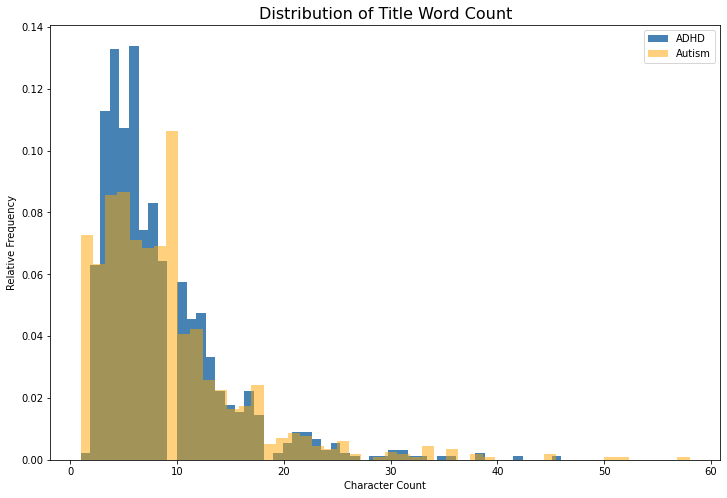

In [15]:
# title word count distribution
plt.figure(figsize = (12,8))
plt.hist(x = df[df['subreddit'] == 'ADHD']['title_word_count'], bins = 50, color = 'steelblue', density = True, label = 'ADHD')
plt.hist(x = df[df['subreddit'] == 'autism']['title_word_count'], bins = 50, color = 'orange', density = True, alpha = 0.5, label = 'Autism')
plt.title("Distribution of Title Word Count", size = 16)
plt.ylabel("Relative Frequency", size = 10)
plt.xlabel("Character Count", size = 10)
plt.legend()

# saving
plt.savefig('./graphs/dist_title_words.jpeg');

Similar to post word count, the title word counts for both subreddits are relatively comparable, r/autism may have some longer titles. Let's check to see if there is a substantial difference.

In [16]:
# counting long titles (>= 25 words - chosen arbitrarily via eyeballing the chart)
df[df['title_word_count'] >= 25].groupby('subreddit')['title_word_count'].count()

subreddit
ADHD      24
autism    33
Name: title_word_count, dtype: int64

Again, I would argue that there isn't a stark contrast between the subreddits' title word counts to suggest that including this feature in our modeling would assist the classification process. 

#### 3c. Examining Stopword Differences
This is worth performing EDA on as well. My hypothesis is that folks with ADHD tend to be more 'wordy' with their sentences when it comes to communication, either via talking, texting, or posting. Let's see if there is major difference.

In [17]:
df[df['post_stopwords_prop'] != 0].groupby('subreddit')['post_stopwords_prop'].mean()

subreddit
ADHD      0.522843
autism    0.520085
Name: post_stopwords_prop, dtype: float64

I ommitted values where the proportion is 0 since those are the posts where the actual text is not included in the post, but rather in the title. Even after accounting for that, the average proportion for both groups is nearly identical, so this will not help differentiate between either subreddits either.

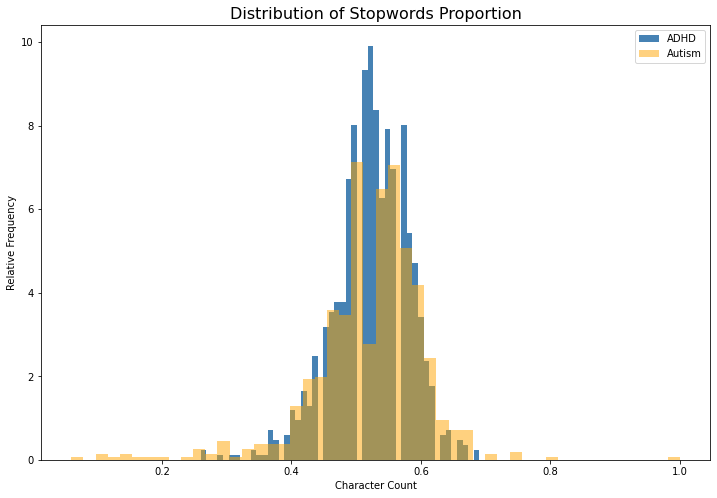

In [18]:
# proportion of stopwords distribution for stopwords_prop != 0
plt.figure(figsize = (12,8))
plt.hist(x = df[(df['subreddit'] == 'ADHD') & (df['post_stopwords_prop'] != 0)]['post_stopwords_prop'], bins = 50, color = 'steelblue', density = True, label = 'ADHD')
plt.hist(x = df[(df['subreddit'] == 'autism') & (df['post_stopwords_prop'] != 0)]['post_stopwords_prop'], bins = 50, color = 'orange', density = True, alpha = 0.5, label = 'Autism')
plt.title("Distribution of Stopwords Proportion", size = 16)
plt.ylabel("Relative Frequency", size = 10)
plt.xlabel("Character Count", size = 10)
plt.legend()

# saving
plt.savefig('./graphs/dist_stopwords_prop.jpeg');

#### 3d. Sentiment Analysis
Let's look at posts from a positive/negative sentiment approach and see if there are any differences there.

In [19]:
df.head()

,post,title,subreddit,post_word_count,title_word_count,post_stopwords_prop,positive post
0,So a bit of backstory I did my lifeguarding qu...,People don't get US At ALL,ADHD,157,6,0.56,1
1,So Adderall IRs were a total no-go for me Swit...,Adderall Making Me Super Anxious AAAAA,ADHD,219,6,0.44,1
2,Regular Ritalin IR works well but I don t like...,Anything that releases methylphenidate constan...,ADHD,61,11,0.43,1
3,I started vyvanse a few months ago 10 mg dose ...,Vyvanse side effects any other paths,ADHD,259,6,0.48,0
4,Evening has anyone who has a documented diagno...,Question GP testing,ADHD,67,3,0.51,0


In [20]:
df[df['post_word_count'] != 0].groupby('subreddit')['positive post'].mean()

subreddit
ADHD      0.556795
autism    0.575650
Name: positive post, dtype: float64

Again, I filtered out the posts where the word count was 0 (meaning empty), since this wouldn't accurately portray a positive/negative score anyways. Even after filtering out, both subreddits have roughly the same split of positive and negative oriented posts.

#### 3e. EDA on Word Counts
So far, none of the variables we made to quantify our data are suggesting stark differences between the posts and titles of the two subreddits. This implies that, overall, the structure, length, and sentiment of posts are relatively similar. <br>
One final thing we can look at, however, is the differences in the words used. My theory is that people posting on r/ADHD discuss more about medications and how well or poorly they perform. There are medicines available to help alleviate symptoms of austism, like anxiety, but my hypothesis is that most people discuss their overall experiences in r/autism in place of discussing medications. <br>
Let's use `CountVectorizer` and examine the top words that appear in both subreddits. If there are several differences, this could help us in the classification modeling process.

In [21]:
# first, let's combine post & title columns so we don't have to vectorize separately
df['post_title'] = df['post'] + ' ' + df['title']

In [22]:
# instantiate countvectorizer & get rid of stopwords
cvec = CountVectorizer(stop_words='english')

# fit cvec object on 'post_title'
cvec.fit(df['post_title'])

CountVectorizer(stop_words='english')

In [25]:
# transform data & then store in a new DF for adhd & aut separately
cvec_adhd = cvec.transform(df[df['subreddit'] == 'ADHD']['post_title'])
cvec_aut = cvec.transform(df[df['subreddit'] == 'autism']['post_title'])

cvec_adhd = pd.DataFrame(cvec_adhd.todense(), columns = cvec.get_feature_names_out())
cvec_aut = pd.DataFrame(cvec_aut.todense(), columns = cvec.get_feature_names_out())

Now we can perform some EDA on word counts on our combined `post` and `title` columns.

In [26]:
# save off top 100 words from r/adhd & r/autism
adhd_top = pd.DataFrame(cvec_adhd.sum().sort_values(ascending = False).head(100)).rename(columns = {0: 'count'})
aut_top = pd.DataFrame(cvec_aut.sum().sort_values(ascending = False).head(100)).rename(columns = {0: 'count'})

In [27]:
# which words are top in r/adhd not in r/autism and vice versa
# let's save these words and plot them

adhd_top_unq = []
aut_top_unq = []

for word in list(adhd_top.index):
    if word not in list(aut_top.index):
        adhd_top_unq.append(word)
        
for word in list(aut_top.index):
    if word not in list(adhd_top.index):
        aut_top_unq.append(word)

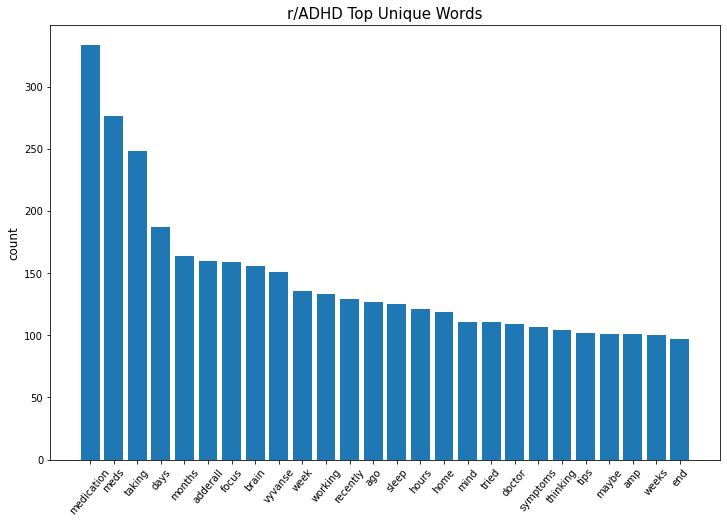

In [28]:
# plot the top occurring words that are unique to each subreddit
plt.figure(figsize = (12,8))
plt.bar(x = adhd_top.loc[adhd_top_unq].index, height = adhd_top.loc[adhd_top_unq]['count'])
plt.title('r/ADHD Top Unique Words', size = 15)
plt.ylabel('count', size = 12)
plt.xticks(rotation = 50);

# save
plt.savefig('./graphs/adhd_top_words.jpeg')

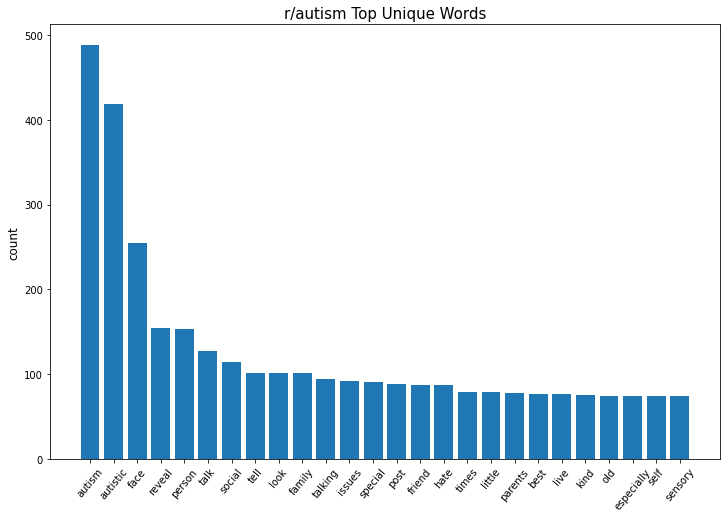

In [29]:
# plot the top occurring words that are unique to each subreddit
plt.figure(figsize = (12,8))
plt.bar(x = aut_top.loc[aut_top_unq].index, height = aut_top.loc[aut_top_unq]['count'])
plt.title('r/autism Top Unique Words', size = 15)
plt.ylabel('count', size = 12)
plt.xticks(rotation = 50);

# save
plt.savefig('./graphs/autism_top_words.jpeg')

Now we have some useful information that helps us distinguish between the two subreddits because several **top** words are unique to each subreddit. After filtering on the top 100 occurring words in each subreddit, I filtered further on the words that are not in the other. <br>
The results are promising since they lend support to my hypothesis above. Of the 26 unique top words in r/ADHD, many of them are about medication (including names), focus, and other words that portray routine/daily tasks like sleep, tried, taking, etc. In r/autism, the 26 unique top words are mostly words that describe social issues. <br>

1. Some r/ADHD Top Unique Words
    > medication <br>
    > adderall <br>
    > focus <br>
    > brain <br>
    > vyvanse <br>
    > sleep <br>
    > mind <br>
    > thinking

2. Some r/autism Top Unique Words
    > autistic <br>
    > person <br>
    > social <br>
    > family <br>
    > talking <br>
    > issues <br> 
    > special <br>
    > hate 
    
For modeling purposes, it may help if we place more emphasis on these words as they come up since they are mentioned several 100s of times while still being the top distinct words between the 2 subreddits.

Before modeling, let's create two final visuals for presentation purposes. [received assistance from ChatGPT for this]

In [30]:
from wordcloud import WordCloud

In [ ]:
# word cloud class
worldcloud = wordcloud()

In [40]:
# converting our dfs to dict
adhd_top_dict = dict(zip(adhd_top.loc[adhd_top_unq].index, adhd_top.loc[adhd_top_unq]['count']))
aut_top_dict = dict(zip(aut_top.loc[aut_top_unq].index, aut_top.loc[aut_top_unq]['count']))

In [51]:
wordcloud_adhd = WordCloud(width=800, height=400, background_color='white', colormap = 'inferno').generate_from_frequencies(adhd_top_dict)
wordcloud_aut = WordCloud(width=800, height=400, background_color='white', colormap = 'rainbow').generate_from_frequencies(aut_top_dict)

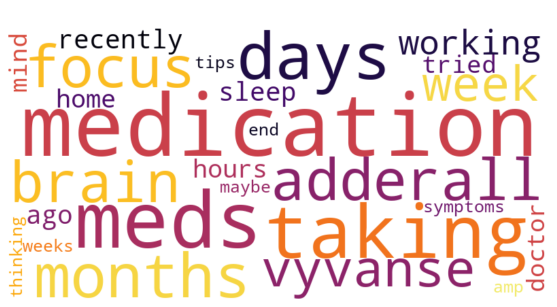

In [55]:
# displaying using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_adhd, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('r/ADHD', size = 20, color = 'white')
plt.show()

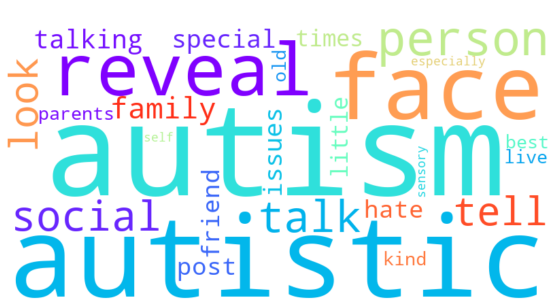

In [56]:
# displaying using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_aut, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('r/autism', size = 20, color = 'white')
plt.show()

Finally, since I noticed that a lot of the quantifiable elements of the posts and titles were roughly similar, let's shorten our dataframe to include just the relevant information. <br>
Below, I am dropping all columns and leaving only the `post_title` (our X) and `subreddit` data so we have a less noisy dataset prior to beginning modeling.

In [62]:
# use this data in the 3rd notebook for modeling
df[['post_title','subreddit']].to_csv('./data/modeling_data.csv')